# Feedforward Neural Network Benchmark

To create a benchmark for comparing future work, this experiment aims to create a simple feedforward neural network and apply it to a substantial amount of our data.

This network will receive pretrained word2vec vectors as input and pass them through three dense layers. One dropout layer will exist after the first dense layer to help reduce overfitting.

Although FFNN have been used in earlier experiments, this is the first to run it over a substantial amount of data.

In [1]:
from sklearn.model_selection import StratifiedKFold
from scripts.cross_validate import run_single_cross_validate
from scripts.feature_extraction import get_balanced_dataset, get_entire_dataset, scaled_reviewer_features
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Embedding, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from exp2_feature_extraction import reviewer_features, reviews_by_reviewer
from metrics import auroc, f1

import numpy as np
import gensim
import nltk
import statistics

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from seaborn import boxplot

Using TensorFlow backend.


In [2]:
all_reviews = get_balanced_dataset()

In [3]:
len(all_reviews)

156692

In [4]:
def clean_review_content(review_content):
  return " ".join([x for x in nltk.word_tokenize(review_content) if x.isalpha()])

In [5]:
reviews_contents = [clean_review_content(x.review_content) for x in all_reviews]
labels = [1 if x.label else 0 for x in all_reviews]

We must convert our reviews to sequences, as this is the input to the 'Embedding' layer of our model that maps words to their embeddings:

In [6]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(reviews_contents)
input_features = np.array(pad_sequences(tokenizer.texts_to_sequences(reviews_contents)))

In [7]:
corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1

We import the word2vec embeddings pretrained by google over a large Google News corpus. We use this to create an embedding matrix, which is a map of sequence identifier (number of the word) to it's vector.

In [8]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format("../../data/GoogleNews-vectors-negative300.bin",
                                                               binary=True)

In [9]:
embedding_length = word_vectors.vector_size
embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
for word, index in corpus_words.items():
  if word in word_vectors.vocab:
    embedding_matrix[index] = np.array(word_vectors[word], dtype=np.float32)

We must calculate the max review length since the Embedding layer of our model uses this:

In [10]:
max_review_len = 0
for input_feature in input_features:
    max_review_len = max(max_review_len, len(input_feature))
print(max_review_len)

320


Checking the number of words in our vocab:

In [11]:
corpus_vocab_size

76783

Checking that our input dataset is roughly balanced:

In [12]:
len([x.label for x in all_reviews if x.label == 0])

78346

Now we create the model described and give our sequences as input. The model converts the sequences to embeddings and passes them through the FFNN

In [13]:
def get_ff_wv_model():
  i1 = Input(shape=(max_review_len,))
  i2 = Input(shape=(5,))
    
  l1 = Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], trainable=False)(i1)
  l2 = Flatten()(l1)
  l3 = Concatenate()([l2, i2])
  l4 = Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01))(l3)
  l5 = Dropout(0.25)(l4)
  l6 = Dense(8, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.l2(0.01))(l5)
  l7 = Dense(1, activation=tf.keras.activations.sigmoid)(l6)

  model = Model(inputs=[i1, i2], outputs=l7)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auroc, f1])
  return model

In [14]:
def evaluate_ffnn_model(train_X, train_y, test_X, test_y):
    ffnn_model = get_ff_wv_model()
    return ffnn_model.fit([x for x in train_X], train_y, epochs=50, batch_size=256, verbose=1, shuffle=False,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=8)],
                   validation_data=([x for x in test_X], test_y))

In [15]:
splitter = StratifiedKFold(n_splits=10, shuffle=True)

In [16]:
reviewer = scaled_reviewer_features(all_reviews, get_entire_dataset())

In [17]:
train_input_features = input_features[:-10000]
train_reviewer = reviewer[:-10000]
train_labels = labels[:-10000]

In [ ]:
bests = []
for cross in range(10):
    ffnn_wv_scores = run_single_cross_validate(evaluate_ffnn_model, [train_input_features, train_reviewer],
                                               train_labels, cross, splitter)
    
    print("Validation Loss:")
    val_loss = ffnn_wv_scores.history['val_loss']
    print(val_loss)
    print("Validation Accuracy:")
    val_accuracy = ffnn_wv_scores.history['val_acc']
    print(val_accuracy)
    print("Validation F1:")
    val_f1 = ffnn_wv_scores.history['val_f1']
    print(val_f1)
    print("Validation AUROC:")
    val_auroc = ffnn_wv_scores.history['val_auroc']
    print(val_f1)

    min_val_loss = 1
    best = None
    for loss, accuracy, f1_score, auroc_score in zip(val_loss, val_accuracy, val_f1, val_auroc):
        if loss < min_val_loss:
            min_val_loss = loss
            best = { 'val_loss': loss, 'val_accuracy': accuracy, 'val_f1': f1_score, 'val_auroc': auroc_score }
    print("best:", best)
    bests.append(best)

Train on 132021 samples, validate on 14671 samples
Epoch 1/50
132021/132021 [==============================] - 44s 336us/step - loss: 0.7748 - acc: 0.6569 - auroc: 0.7101 - f1: 0.6546 - val_loss: 0.6993 - val_acc: 0.6923 - val_auroc: 0.7512 - val_f1: 0.7025
Epoch 2/50
132021/132021 [==============================] - 44s 331us/step - loss: 0.7135 - acc: 0.6848 - auroc: 0.7419 - f1: 0.6853 - val_loss: 0.6984 - val_acc: 0.6961 - val_auroc: 0.7554 - val_f1: 0.7144
Epoch 3/50
132021/132021 [==============================] - 44s 333us/step - loss: 0.7043 - acc: 0.6878 - auroc: 0.7450 - f1: 0.6881 - val_loss: 0.6868 - val_acc: 0.6976 - val_auroc: 0.7549 - val_f1: 0.6947
Epoch 4/50
132021/132021 [==============================] - 44s 334us/step - loss: 0.7013 - acc: 0.6881 - auroc: 0.7458 - f1: 0.6876 - val_loss: 0.6987 - val_acc: 0.6962 - val_auroc: 0.7578 - val_f1: 0.7229
Epoch 5/50
132021/132021 [==============================] - 44s 333us/step - loss: 0.7016 - acc: 0.6889 - auroc: 0.7463 -

Train on 132023 samples, validate on 14669 samples
Epoch 1/50
132023/132023 [==============================] - 44s 334us/step - loss: 0.7599 - acc: 0.6622 - auroc: 0.7172 - f1: 0.6632 - val_loss: 0.6979 - val_acc: 0.6975 - val_auroc: 0.7594 - val_f1: 0.7188
Epoch 2/50
132023/132023 [==============================] - 43s 324us/step - loss: 0.7151 - acc: 0.6832 - auroc: 0.7401 - f1: 0.6830 - val_loss: 0.6988 - val_acc: 0.6893 - val_auroc: 0.7590 - val_f1: 0.7238
Epoch 3/50
132023/132023 [==============================] - 44s 330us/step - loss: 0.7106 - acc: 0.6852 - auroc: 0.7429 - f1: 0.6851 - val_loss: 0.6967 - val_acc: 0.6995 - val_auroc: 0.7600 - val_f1: 0.7179
Epoch 4/50
132023/132023 [==============================] - 43s 325us/step - loss: 0.7104 - acc: 0.6853 - auroc: 0.7437 - f1: 0.6842 - val_loss: 0.6891 - val_acc: 0.7018 - val_auroc: 0.7639 - val_f1: 0.7247
Epoch 5/50
132023/132023 [==============================] - 43s 325us/step - loss: 0.7082 - acc: 0.6861 - auroc: 0.7451 -

Train on 132023 samples, validate on 14669 samples
Epoch 1/50
132023/132023 [==============================] - 45s 343us/step - loss: 0.7615 - acc: 0.6625 - auroc: 0.7160 - f1: 0.6600 - val_loss: 0.7017 - val_acc: 0.6906 - val_auroc: 0.7503 - val_f1: 0.7088
Epoch 2/50
132023/132023 [==============================] - 44s 332us/step - loss: 0.7111 - acc: 0.6848 - auroc: 0.7420 - f1: 0.6855 - val_loss: 0.6890 - val_acc: 0.6943 - val_auroc: 0.7549 - val_f1: 0.7066
Epoch 3/50
132023/132023 [==============================] - 44s 332us/step - loss: 0.7075 - acc: 0.6858 - auroc: 0.7427 - f1: 0.6877 - val_loss: 0.6980 - val_acc: 0.6846 - val_auroc: 0.7402 - val_f1: 0.6920
Epoch 4/50
132023/132023 [==============================] - 44s 332us/step - loss: 0.7041 - acc: 0.6838 - auroc: 0.7421 - f1: 0.6857 - val_loss: 0.6914 - val_acc: 0.6925 - val_auroc: 0.7497 - val_f1: 0.6985
Epoch 5/50
132023/132023 [==============================] - 44s 332us/step - loss: 0.7048 - acc: 0.6862 - auroc: 0.7440 -

In [20]:
print("==============================================================")
for best in bests:
  print(best)
  print("==============================================================")
print("Average accuracy:", statistics.mean([x['val_accuracy'] for x in bests]))

{'val_f1': 0.7240855165659288, 'val_auroc': 0.7716540556686994, 'val_accuracy': 0.714607048043606, 'val_loss': 0.6732355435196343}
{'val_f1': 0.718812044099663, 'val_auroc': 0.7610934306845143, 'val_accuracy': 0.7043424910079792, 'val_loss': 0.6966541145661994}
{'val_f1': 0.7226795409669888, 'val_auroc': 0.7649041749196194, 'val_accuracy': 0.7066603040831717, 'val_loss': 0.6847531079709616}
{'val_f1': 0.6988804128664274, 'val_auroc': 0.7606790216029338, 'val_accuracy': 0.7018201649900074, 'val_loss': 0.6767350786164118}
{'val_f1': 0.7137401629602733, 'val_auroc': 0.7580518727327646, 'val_accuracy': 0.6967755130759631, 'val_loss': 0.6889497483911929}
{'val_f1': 0.731433466380583, 'val_auroc': 0.7709812828045498, 'val_accuracy': 0.7128638626323317, 'val_loss': 0.6851975975027519}
{'val_f1': 0.715971848034844, 'val_auroc': 0.7588348850443973, 'val_accuracy': 0.695343922452129, 'val_loss': 0.684315042490364}
{'val_f1': 0.7249707128382532, 'val_auroc': 0.764970304355763, 'val_accuracy': 0.7

It seems that our FFNN has not immediately shown improvements over the earlier statistical experiments. It is possible to perform more precise hypertuning, although at this stage it is unlikely we will see a dramatic increase in accuracy.

Our results look good for a benchmark, with just a little variance seen in this data. The following graph shows the distribution:

Text(0.5, 1.0, 'Feed-Forward Neural Network Accuracies')

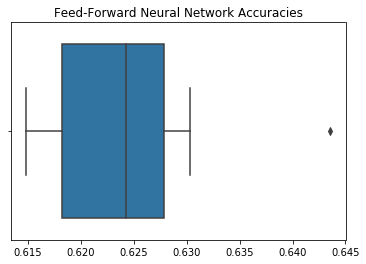

In [5]:
from seaborn import boxplot
from pandas import DataFrame
boxplot(DataFrame([ff_wv_scores['accuracies']])).set_title("Feed-Forward Neural Network Accuracies")

Text(0.5, 1.0, 'Feed-Forward Neural Network AUC scores')

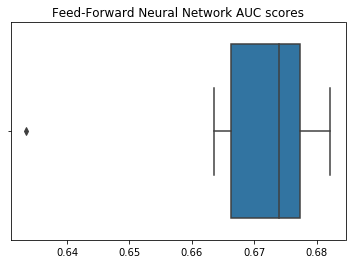

In [6]:
boxplot(DataFrame([ff_wv_scores['auc']])).set_title("Feed-Forward Neural Network AUC scores")

Text(0.5, 1.0, 'Feed-Forward Neural Network F1 scores')

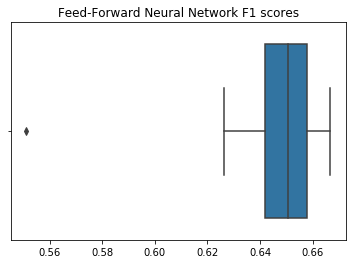

In [7]:
boxplot(DataFrame([ff_wv_scores['f1-score']])).set_title("Feed-Forward Neural Network F1 scores")

We have one outlier in our results, the second cross validation. For this validation it is actually more accurate than the others, but for the AUC and F1 score it is slightly lower. It's not a very distant outlier, so it appears that this is a suitable benchmark for Feed-Forward neural networks.